In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

from math import ceil, floor, pi, acos, prod
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from IPython.display import clear_output

from ghost.multisim import GhostSimulator, GhostAnalyser, SLMPattern, AlignmentHelper


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sys.path.append(os.getenv("HEDS_PYTHON_MODULES", ""))
from holoeye import slmdisplaysdk

ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

slm = slmdisplaysdk.SLMDisplay()


In [ ]:
from io import StringIO
import matlab.engine

eng = matlab.engine.start_matlab()
eng.addpath(r'../src/ghost/', nargout=0)

In [ ]:
# rewriting hong's algo in python

size = 8.5 #nm
mag = 45
slm_res = 8 #um
lens_size = ceil(mag * size / slm_res) 
xslm, yslm = 1080, 1920
x_pattern_size, y_pattern_size = ceil(xslm / lens_size), ceil(yslm / lens_size)

amp_pattern = np.zeros((x_pattern_size, y_pattern_size))
ph_pattern = np.zeros((x_pattern_size, y_pattern_size))

# amp_pattern[10:15, 10:15] = 1
amp_pattern = 1
amp_pattern = np.kron(np.ones((x_pattern_size, y_pattern_size)), np.array([[1, 0], [0, 1]]))
amp_pattern = amp_pattern[:x_pattern_size, :y_pattern_size]

plt.imshow(amp_pattern)
plt.show()

print(f'Aperture size in pixel: {lens_size}')

# define pixel array
pixel = lambda a, b, xg, yg: np.array([[a, b], [b, a]]).repeat(xg, axis=2).repeat(yg, axis=3).transpose(2,0,3,1).reshape(2*a.shape[0]*xg, 2*a.shape[1]*yg)

plt.imshow(pixel(np.array([[1]]), np.array([[0]]), lens_size//2, lens_size//2), interpolation='nearest', cmap='gray')
plt.show()

print("pattern size: ", x_pattern_size, y_pattern_size)
print("pattern size in pixel: ", lens_size*x_pattern_size, lens_size*y_pattern_size)

x_redun = xslm - lens_size*x_pattern_size/2
y_redun = yslm - lens_size*y_pattern_size/2

# eslm = lambda p1, p2: 2 * sympy.cos((p1- p2)/2) * sympy.exp(sympy.i * (p1 - p2) / 2)

p1 = lambda ph, amp: ph + np.arccos(amp)
p2 = lambda ph, amp: ph - np.arccos(amp)
ph_ref = pi/2

p1_data = p1(ph_pattern + ph_ref, amp_pattern) / (2 * pi)
p2_data = p2(ph_pattern + ph_ref, amp_pattern) / (2 * pi)

amp_phase = pixel(p1_data, p2_data, lens_size//2, lens_size//2)
amp_phase = amp_phase[:xslm, :yslm]
amp_phase = np.resize(amp_phase, (xslm, yslm))

print("amplitude phase shape: ", amp_phase.shape)
plt.imshow(amp_phase, interpolation='nearest', cmap='gray')
plt.show()

k = 2 * pi / 0.632
theta = 0.5 * pi / 180

X, Y = np.mgrid[0:lens_size*x_pattern_size, 0:lens_size*y_pattern_size]
phase_gradient = np.mod(8*k*X*np.sin(theta), 2*pi) / (2 * pi)

PG = np.kron(amp_pattern > 0, np.ones((lens_size, lens_size))) * phase_gradient
PG = PG[:xslm, :yslm]

tot_phase = np.mod(amp_phase + PG, 1)

print("grad phase shape: ", tot_phase.shape)
plt.imshow(tot_phase, interpolation='nearest', cmap='gray')
plt.show()

slm.showPhasevalues(tot_phase)

In [93]:

path = '../common/cat.png'
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
spacing = (1, 1)
n = prod(mac_res)
sigma = 0

# pattern constants
k = 2 * pi / 0.632
theta = 0.5 * pi / 180
slm_shift = (300, 480)
lens_size = 14
slm_phys_res = (1080, 1920)

# pf32 config
frame_time=100
acq_time=500

# save path
savepath = r'D:\2022-2-16, Cat trial'

sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, spacing=spacing, shift=shift, sigma=sigma, method='zigzag')
pg = SLMPattern(lens_size, slm_phys_res, k, theta)


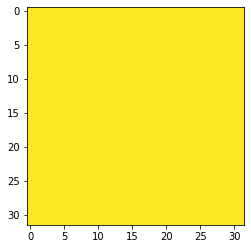

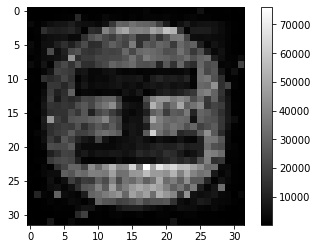

In [94]:
# ALIGNMENT
slm_shift = (300, 480)
lens_size = 14

ah = AlignmentHelper(slm_res)

filter = ah.ones()
plt.imshow(filter, vmin=0)
plt.show()

pg = SLMPattern(lens_size, slm_phys_res, k, theta)

amp_pattern = np.zeros((pg.xp_size, pg.yp_size))
ph_pattern = np.zeros((pg.xp_size, pg.yp_size))

amp_pattern[:slm_res[0], :slm_res[0]] = filter

pattern = pg.generate_pattern_grad(amp_pattern, ph_pattern)
pattern = np.roll(pattern, slm_shift, axis=(0, 1))

error = slm.showPhasevalues(pattern)
assert error == ErrorCode.NoError, slm.errorString(error)

filename = os.path.join(savepath, f'ones.csv')
out = StringIO()
frame_num = int((acq_time/1000)/(frame_time*1e-6))
eng.capture(frame_time, acq_time, filename, stdout=out)
# print(out.getvalue())
x = np.loadtxt(filename, delimiter=',')
plt.imshow(x, cmap='gray')
plt.colorbar()
plt.show()



cali: 15


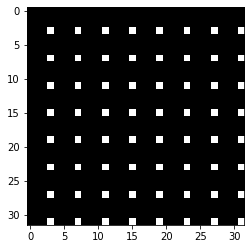

In [95]:
# PIXEL CALLIBRATION

for i in range(prod(spacing) * prod(mac_res)):
# for i in range(2):
    clear_output(wait=True)
    filter = sim.generate_cali_pattern(i)

    amp_pattern = np.zeros((pg.xp_size, pg.yp_size))
    ph_pattern = np.zeros((pg.xp_size, pg.yp_size))
    amp_pattern[:slm_res[0], :slm_res[0]] = filter

    pattern = pg.generate_pattern_binary(amp_pattern, ph_pattern)
    pattern = np.roll(pattern, slm_shift, axis=(0, 1))

    print(f'cali: {i}')
    plt.imshow(filter, interpolation='nearest', cmap='gray')
    plt.show()

    # # SLM display pattern
    error = slm.showPhasevalues(pattern)
    assert error == ErrorCode.NoError, slm.errorString(error)

    # pf32 capture image
    filename = os.path.join(savepath, f'cali_{i}.csv')
    out = StringIO()
    
    eng.capture(frame_time, acq_time, filename, stdout=out)
    # print(out.getvalue())
    # x = np.loadtxt(filename, delimiter=',')
    # plt.imshow(x, cmap='gray')
    # plt.colorbar()
    # plt.show()


n: 15p


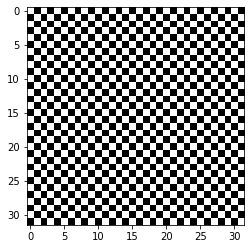

In [82]:
# IMAGE MEASUREMENT

for i in range(prod(spacing) * prod(mac_res)):
# for i in range(1):
    for sign in (-1, 1):
        clear_output(wait=True)
        s = sim.generate_filter2(i)
        filter = s == sign

        amp_pattern = np.zeros((pg.xp_size, pg.yp_size))
        ph_pattern = np.zeros((pg.xp_size, pg.yp_size))

        amp_pattern[:slm_res[0], :slm_res[0]] = filter

        pattern = pg.generate_pattern_grad(amp_pattern, ph_pattern)
        pattern = np.roll(pattern, slm_shift, axis=(0, 1))

        print(f'n: {i}{"p" if sign > 0 else "m"}')
        plt.imshow(filter, interpolation='nearest', cmap='gray')
        plt.show()

        # # SLM display pattern
        error = slm.showPhasevalues(pattern)
        assert error == ErrorCode.NoError, slm.errorString(error)

        # pf32 capture image
        filename = os.path.join(savepath, f'{i}{"p" if sign > 0 else "m"}.csv')
        out = StringIO()
        frame_num = int((acq_time/1000)/(frame_time*1e-6))
        eng.capture(frame_time, acq_time, filename, stdout=out)
        # print(out.getvalue())
        # x = np.loadtxt(filename, delimiter=',')
        # plt.imshow(x, cmap='gray')
        # plt.colorbar()
        # plt.show()
        # time.sleep(2)

In [ ]:
x = np.loadtxt(r'D:\2022-2-16, Cat trial\trial3\0p.csv', delimiter=',')
plt.imshow(x, cmap='gray')
plt.colorbar()
plt.show()

In [92]:
# 

0.0